<a href="https://colab.research.google.com/github/pampamda/Chexpert_LLaVA-1.5-7B/blob/finetune/LLava_Model_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
from pathlib import Path

print("\nMounting Google Drive...")
drive.mount('/content/drive')


Mounting Google Drive...
Mounted at /content/drive


In [ ]:
!pip install -U transformers

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-80onf0kt/unsloth_c5493b9d12b34b8f92cf9ec78c958462
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-80onf0kt/unsloth_c5493b9d12b34b8f92cf9ec78c958462
  Resolved https://github.com/unslothai/unsloth.git to commit 3d98df6e0f7da49437731eadd5bde767fc1b20af
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached datasets-4.2.0-py3-none-any.whl.metadata (18 kB)
  Using cached pyarrow-21.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
Using cached datasets-4.2.0-py3-none-any.whl (506 kB)
Using cached pyarrow-21.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (42.8 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.0
    Uninstalling pyarrow-14.0.0:
      Successfully uninstalled pyarrow-14.0.0
  Attempting uninstall: datasets
    Fo

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, LlavaProcessor
import torch
from PIL import Image

In [ ]:
DRIVE_DATA_PATH = "/content/drive/MyDrive/Group_Project/IS"
CSV_FILE = "data/processed_chexpert_reports_2000.csv"
IMAGE_FOLDER = "data/filtered_chexpert_images_2000"
MODEL_FOLDER = "llava_finetuned_mvp2000_v2"

csv_path = os.path.join(DRIVE_DATA_PATH, CSV_FILE)
image_folder_path = os.path.join(DRIVE_DATA_PATH, IMAGE_FOLDER)
model_output_path = os.path.join(DRIVE_DATA_PATH, MODEL_FOLDER)

print(image_folder_path)
print(model_output_path)

#---------------------
BASE_MODEL_ID = "llava-hf/llava-1.5-7b-hf"
MED_MODEL_ID = "YuchengShi/llava-med-v1.5-mistral-7b-chest-xray"
finetuned_model_path  = model_output_path

/content/drive/MyDrive/Group_Project/IS/data/filtered_chexpert_images_2000
/content/drive/MyDrive/Group_Project/IS/llava_finetuned_mvp2000_v2


In [ ]:
def load_llava_model(model_id):
    processor = AutoProcessor.from_pretrained(model_id)
    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    return processor, model


def generate_report(processor, model, image, question, max_new_tokens=512):
    prompt = f"{question}"

    inputs = processor(
        images=image,
        text=prompt,
        return_tensors="pt",
        truncation=False,        # ✅ 禁止截断
        max_length=None,         # ✅ 不设最大长度
        padding=False            # ✅ 不需要 padding
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 3️⃣ 推理
    model.eval()
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)

    # 4️⃣ 解码
    response = processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    return response


In [ ]:
from unsloth import FastLanguageModel

processor_finetuned = LlavaProcessor.from_pretrained(finetuned_model_path)
model_finetuned, tokenizer_finetuned = FastLanguageModel.from_pretrained(
    model_name = finetuned_model_path,
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True,
)

==((====))==  Unsloth 2025.10.3: Fast Clip patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


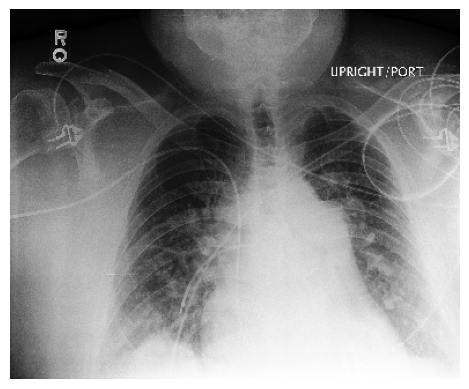

In [ ]:
import json
import matplotlib.pyplot as plt

with open("/content/drive/MyDrive/Group_Project/IS/data/training_data_2000.json", "r") as f:
    data = json.load(f)

sample = data[0]   # 随便取一条
image = Image.open(sample["image"]).convert("RGB")
question = sample["conversations"][0]["value"]

plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
answer = sample["conversations"][1]["value"]

print("==== Original Report ====")
print(answer)

==== Original Report ====
IMPRESSION: 1. LINES AND TUBES ARE UNCHANGED. 2. LOW LUNG VOLUMES AND LEFT BASILAR ATELECTASIS OR CONSOLIDATION, ALSO UNCHANGED. __________________________________

FINDINGS: 

SUMMARY: 


In [ ]:
report_finetuned = generate_report(processor_finetuned, model_finetuned, image, question)
print("\n==== Fine-tuned Model ====")
print(report_finetuned)


==== Fine-tuned Model ====

You are an experienced radiologist. Analyze this chest X-ray image and generate a comprehensive diagnostic report including FINDINGS, IMPRESSION AND SUMMARY sections.

FINDINGS:

1. The patient has a large right pleural effusion.
2. The right lung is collapsed.
3. The left lung is normal.
4. The heart is enlarged.
5. The aorta is dilated.

IMPRESSION:

The patient has a large right pleural effusion, which is likely due to a malignant process. The right lung is collapsed, and the heart is enlarged. The aorta is dilated. The left lung is normal.

SUMMARY:

The patient has a large right pleural effusion, which is likely due to a malignant process. The right lung is collapsed, and the heart is enlarged. The aorta is dilated. The left lung is normal.


In [ ]:
# 原始 LLaVA
processor_base, model_base = load_llava_model(BASE_MODEL_ID)
report_base = generate_report(processor_base, model_base, image, question)

print("==== Original LLaVA ====")
print(report_base)

==== Original LLaVA ====

You are an experienced radiologist. Analyze this chest X-ray image and generate a comprehensive diagnostic report including FINDINGS, IMPRESSION AND SUMMARY sections.

FINDINGS:

* The chest X-ray shows a clear view of the lungs and the heart.
* The heart is located in the upper left quadrant of the image.
* The lungs are visible in the lower half of the image, with the right lung occupying the majority of the space.
* There are no signs of significant pathology or abnormalities in the image.

IMPRESSION:

* The chest X-ray is a clear and well-defined image, providing a comprehensive view of the lungs and the heart.
* The heart appears to be in a healthy state, with no signs of abnormalities or pathology.
* The lungs are also in good condition, with no signs of infection or other abnormalities.

SUMMARY:

* The chest X-ray is a clear and well-defined image, providing a comprehensive view of the lungs and the heart.
* The heart appears to be in a healthy state,

In [ ]:
# 医学版 LLaVA-Med
processor_med, model_med = load_llava_model(MED_MODEL_ID)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://i.ibb.co/mC6kRFrQ/patient30791-study3-view1-frontal.jpg"},
            {"type": "text", "text": "You are an experienced radiologist. Analyze this chest X-ray image and generate a comprehensive diagnostic report including FINDINGS, IMPRESSION AND SUMMARY sections."}
        ]
    },
]
# <a href="https://imgbb.com/"><img src="https://i.ibb.co/mC6kRFrQ/patient30791-study3-view1-frontal.jpg" alt="patient30791-study3-view1-frontal" border="0"></a>

inputs = processor_med.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model_med.device)

outputs = model_med.generate(**inputs, max_new_tokens=40)

print("\n==== LLaVA-Med ====")
print(processor_med.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

# print(report_med)

In [ ]:
from unsloth import FastLanguageModel
from PIL import Image

# Load the LLaVA-Med model using Unsloth with 4-bit quantization
print("\nLoading LLaVA-Med model using Unsloth...")
try:
    model_med, tokenizer_med = FastLanguageModel.from_pretrained(
        model_name = "YuchengShi/llava-med-v1.5-mistral-7b-chest-xray",
        max_seq_length = 2048, # Adjust if needed based on expected report length
        dtype = torch.float16, # Use float16 for reduced memory usage
        load_in_4bit = True,   # Enable 4-bit quantization
    )
    # Use the AutoProcessor for the LLaVA-Med model
    processor_med = AutoProcessor.from_pretrained("YuchengShi/llava-med-v1.5-mistral-7b-chest-xray")
    print("✅ LLaVA-Med model loaded successfully with Unsloth.")
except Exception as e:
    print(f"❌ Failed to load LLaVA-Med model with Unsloth: {e}")
    import sys
    sys.exit(1)

# Now use the loaded model and processor for inference with the generate_report function
print("\nGenerating report with LLaVA-Med model...")

# Use the 'image' and 'question' variables defined in a previous cell (R4ZV0Y9LuB1-)
if 'image' not in globals() or 'question' not in globals():
    print("❌ Image or question variable not found. Please run the cell that loads the example data.")
else:
    try:
        report_med = generate_report(processor_med, model_med, image, question)
        print("\n==== LLaVA-Med ====")
        print(report_med)
    except Exception as e:
        print(f"❌ Error during report generation with LLaVA-Med: {e}")

/tmp/ipython-input-354278638.py:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel
/usr/local/lib/python3.12/dist-packages/unsloth/__init__.py:202: UserWarning: Unsloth: Running `ldconfig /usr/lib64-nvidia` to link CUDA.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/unsloth/__init__.py:236: UserWarning: Unsloth: CUDA is not linked properly.
Try running `python -m bitsandbytes` then `python -m xformers.info`
We tried running `ldconfig /usr/lib64-nvidia` ourselves, but it didn't work.
You need to run in your terminal `sudo ldconfig /usr/lib64-nvidia` yourself, then import Unsloth.
Also try `sudo ldconfig /usr/local/cuda-xx.x` - find the latest cuda version.
Unsloth will still run for now, but maybe it might crash - let

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


AttributeError: module 'bitsandbytes' has no attribute 'functional'